In [31]:
import pandas as pd
import numpy as np

hr = pd.read_csv('./data/xml_export/HeartRate.csv', low_memory=False)
#rhr = pd.read_csv('./data/xml_export/RestingHeartRate.csv', low_memory=False)
#
#hr = pd.concat([hr, rhr], axis=0)
hrv = pd.read_csv('./data/xml_export/HeartRateVariabilitySDNN.csv', low_memory=False)

# Only keep if creationDate is > 9/25/2020
hr = hr[hr['creationDate'] > '2020-09-25']
hrv = hrv[hrv['creationDate'] > '2020-09-25']

sleep = pd.read_csv('./data/train.csv', low_memory=False)

In [2]:
hr.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
0,Polar Flow,NaN,NaN,HeartRate,count/min,2015-04-22 09:12:25 -0400,2015-04-20 18:31:34 -0400,2015-04-20 18:31:34 -0400,113.0
1,Polar Flow,NaN,NaN,HeartRate,count/min,2015-04-22 09:12:25 -0400,2015-04-20 19:01:59 -0400,2015-04-20 19:01:59 -0400,122.0
2,Polar Flow,NaN,NaN,HeartRate,count/min,2015-04-22 09:12:25 -0400,2015-04-20 18:56:05 -0400,2015-04-20 18:56:05 -0400,137.0
3,Polar Flow,NaN,NaN,HeartRate,count/min,2015-04-22 09:12:25 -0400,2015-04-20 18:30:07 -0400,2015-04-20 18:30:07 -0400,110.0
4,Polar Flow,NaN,NaN,HeartRate,count/min,2015-04-22 09:12:25 -0400,2015-04-20 18:41:32 -0400,2015-04-20 18:41:32 -0400,115.0


In [3]:
# If sourceName is Polar Flow, delete
hr = hr[hr['sourceName'] != 'Polar Flow']
hr.head()

,sourceName,sourceVersion,device,type,unit,creationDate,startDate,endDate,value
71560,Rob’s Apple Watch,7.0,"<<HKDevice: 0x28043b890>, name:Apple Watch, ma...",HeartRate,count/min,2020-09-25 20:08:19 -0400,2020-09-25 20:03:41 -0400,2020-09-25 20:03:41 -0400,58.0
71561,Rob’s Apple Watch,7.0,"<<HKDevice: 0x28043b890>, name:Apple Watch, ma...",HeartRate,count/min,2020-09-25 20:12:02 -0400,2020-09-25 20:11:01 -0400,2020-09-25 20:11:01 -0400,60.0
71562,Rob’s Apple Watch,7.0,"<<HKDevice: 0x28043b890>, name:Apple Watch, ma...",HeartRate,count/min,2020-09-25 20:12:28 -0400,2020-09-25 20:10:49 -0400,2020-09-25 20:10:49 -0400,61.0
71563,Rob’s Apple Watch,7.0,"<<HKDevice: 0x28043b890>, name:Apple Watch, ma...",HeartRate,count/min,2020-09-25 20:16:28 -0400,2020-09-25 20:16:27 -0400,2020-09-25 20:16:27 -0400,59.0
71564,Rob’s Apple Watch,7.0,"<<HKDevice: 0x28043b890>, name:Apple Watch, ma...",HeartRate,count/min,2020-09-25 20:16:32 -0400,2020-09-25 20:16:31 -0400,2020-09-25 20:16:31 -0400,58.0


In [4]:

hr["date"] = pd.to_datetime(hr["creationDate"]).dt.date
hr["hour"] = pd.to_datetime(hr["creationDate"]).dt.hour
hr_hour = hr.groupby(["date","hour"])[["value"]].mean().reset_index()
hr_hour.head()


,date,hour,value
0,2020-09-25,20,61.826687
1,2020-09-25,21,61.071429
2,2020-09-25,22,71.583333
3,2020-09-25,23,60.363636
4,2020-09-26,0,63.615385


In [5]:
mean = hr_hour["value"].mean()
median = hr_hour["value"].median()

In [6]:
threshold = mean

df = hr_hour.copy()
df['datetime'] = pd.to_datetime(df['date']) + pd.to_timedelta(df['hour'], unit='h')

# Find min and max times for each day when HR is below the threshold
min_max_times = df[df['value'] < threshold].groupby(df['datetime'].dt.date).agg({'datetime': ['min', 'max']}).reset_index()

# Flatten column names
min_max_times.columns = ['_'.join(col).strip() for col in min_max_times.columns.values]

# Calculate sleep duration in hours and merge with the original dataframe
min_max_times['sleep_pred'] = (min_max_times['datetime_min'].shift(-1) - min_max_times['datetime_max']).dt.total_seconds() / 3600
df = df.merge(min_max_times[['datetime_max', 'sleep_pred']], left_on='datetime', right_on='datetime_max', how='left').drop('datetime_max', axis=1)

hr_hour = df.groupby('date')['sleep_pred'].sum().reset_index()

hr_hour['date'] = hr_hour['date'].astype('datetime64[ns]')
sleep['date'] = sleep['date'].astype('datetime64[ns]')

hr_hour = hr_hour.merge(sleep, on='date', how='left')

# Calculate RMSE between sleep_pred and sleep_hours
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(np.nanmean((hr_hour['sleep_hours'] - hr_hour['sleep_pred']) ** 2))
print(rmse)


5.592580274224768


In [7]:

import pandas as pd

# Define threshold heart rate value
sleep_hr_threshold = 62

# Define threshold percentage reduction in heart rate below awake period average
sleep_hr_reduction = 0.1

# Load heart rate data into a pandas dataframe
df = hr.copy()

# Convert timestamp column to datetime format
df['date'] = pd.to_datetime(df['startDate'])

# Compute hourly heart rate
hourly_hr = df.groupby(pd.Grouper(key='date', freq='H'))['value'].mean()

# Compute rolling average heart rate over 4 hours
rolling_hr = hourly_hr.rolling(window=4, min_periods=1).mean()

# Compute nighttime heart rate average for each day
night_hr_avg = rolling_hr.between_time('22:00', '06:00').resample('D').mean()



# Identify sleep periods based on heart rate data
is_sleep = rolling_hr < (1 - sleep_hr_reduction) * night_hr_avg.reindex(rolling_hr.index, method='ffill')

# Compute total sleep time by date
sleep_time_by_date = is_sleep.resample('D').sum() * pd.Timedelta(hours=1)

sleep_time_by_date = sleep_time_by_date.dt.total_seconds() / 3600

# Replace 0s with NaNs
sleep_time_by_date[sleep_time_by_date == 0] = np.nan

print(sleep_time_by_date)


date
2020-09-25 00:00:00-04:00    NaN
2020-09-26 00:00:00-04:00    2.0
2020-09-27 00:00:00-04:00    NaN
2020-09-28 00:00:00-04:00    NaN
2020-09-29 00:00:00-04:00    NaN
                            ... 
2023-03-14 00:00:00-04:00    7.0
2023-03-15 00:00:00-04:00    8.0
2023-03-16 00:00:00-04:00    NaN
2023-03-17 00:00:00-04:00    5.0
2023-03-18 00:00:00-04:00    NaN
Freq: D, Name: value, Length: 905, dtype: float64


In [8]:
sleep_time_by_date = sleep_time_by_date.reset_index()
sleep_time_by_date["date"] = sleep_time_by_date["date"].dt.date
sleep["date"] = sleep["date"].dt.date

test = sleep.merge(sleep_time_by_date, on='date', how='left')


rmse = np.sqrt(np.nanmean((test['sleep_hours'] - test['value']) ** 2))
print(rmse)


3.236536509150424


In [9]:
sleep_time_by_date

,date,value
0,2020-09-25,NaN
1,2020-09-26,2.0
2,2020-09-27,NaN
3,2020-09-28,NaN
4,2020-09-29,NaN
...,...,...
900,2023-03-14,7.0
901,2023-03-15,8.0
902,2023-03-16,NaN
903,2023-03-17,5.0


In [10]:
import pandas as pd
import numpy as np
from datetime import timedelta

def estimate_sleep_lengths(df, sleep_start_hour = 22, sleep_end_hour = 8, threshold_factor=0.8, window_size=3):

    # Convert timestamp to datetime format
    df['timestamp'] = pd.to_datetime(df['endDate'])

    # Remove duplicate entries
    df = df.drop_duplicates(subset=['timestamp'])

    # Sort by timestamp
    df = df.sort_values(by=['timestamp'])

    # Create a new DataFrame with a fixed 5-minute interval
    date_range = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='5T')
    df_resampled = pd.DataFrame(date_range, columns=['timestamp'])

    # Merge the original DataFrame with the resampled DataFrame
    df_resampled = pd.merge(df_resampled, df, on='timestamp', how='left')

    # Fill missing values using interpolation
    df_resampled['value'] = df_resampled['value'].interpolate()

    # Calculate the average heart rate
    avg_heart_rate = df_resampled['value'].mean()

    # Apply rolling average
    df_resampled['rolling_avg_hr'] = df_resampled['value'].rolling(window=window_size, min_periods=1).mean()

    # Calculate the sleep threshold based on the rolling average heart rate
    sleep_threshold = avg_heart_rate * threshold_factor

    # Create binary sleep column based on heart rate drop and time of day
    df_resampled['hour'] = df_resampled['timestamp'].dt.hour
    df_resampled['sleep'] = np.where((df_resampled['rolling_avg_hr'] <= sleep_threshold) & 
                                     ((df_resampled['hour'] >= sleep_start_hour) | 
                                      (df_resampled['hour'] < sleep_end_hour)), 1, 0)

    # Calculate estimated sleep hours for each day
    df_resampled['day'] = df_resampled['timestamp'].dt.floor('D')
    df_sleep = df_resampled.groupby('day').agg({'sleep': 'sum'})
    df_sleep['sleep_hours'] = df_sleep['sleep'] * 5 / 60

    return df_sleep

In [11]:



import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.signal import medfilt

def estimate_sleep_lengths(df, sleep_start_hour, sleep_end_hour, feature, resample_freq='5T', window_size=3, num_gaussians=2, min_sleep_duration=45):
    # Make sure timestamp is a datetime object
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.drop_duplicates(subset=['timestamp']).sort_values(by=['timestamp'])

    # Create a new DataFrame with a fixed interval, merge and interpolate
    df_resampled = pd.DataFrame(pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq=resample_freq), columns=['timestamp'])
    df_resampled = pd.merge(df_resampled, df, on='timestamp', how='left').fillna(method='ffill')

    # Apply moving average filter to the feature
    df_resampled['filtered_feature'] = df_resampled[feature].rolling(window=window_size, min_periods=1).mean()

    # Fit a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=num_gaussians, random_state=42)
    gmm.fit(df_resampled['filtered_feature'].values.reshape(-1, 1))

    # Get cluster labels and identify sleep cluster
    df_resampled['cluster'] = gmm.predict(df_resampled['filtered_feature'].values.reshape(-1, 1))
    cluster_mean_diff = gmm.means_[1][0] - gmm.means_[0][0]
    sleep_cluster = 1 if cluster_mean_diff < 0 else 0

    # Create binary sleep column based on cluster label and time of day
    df_resampled['sleep'] = np.where((df_resampled['cluster'] == sleep_cluster) & 
                                     ((df_resampled['timestamp'].dt.hour >= sleep_start_hour) | 
                                      (df_resampled['timestamp'].dt.hour < sleep_end_hour)), 1, 0)

    # Apply median filter to smooth sleep transitions
    df_resampled['sleep'] = medfilt(df_resampled['sleep'], kernel_size=3)

    # Add minimum sleep duration constraint
    min_duration_points = min_sleep_duration * 60 // pd.to_timedelta(resample_freq).seconds
    df_resampled['sleep'] = (df_resampled['sleep'].groupby((df_resampled['sleep'] != df_resampled['sleep'].shift()).cumsum()).transform('sum') * 5 >= min_duration_points).astype(int)

    # Calculate estimated sleep hours for each day
    df_sleep = df_resampled.groupby(df_resampled['timestamp'].dt.floor('D')).agg({'sleep': 'sum'})
    df_sleep['sleep_hours'] = df_sleep['sleep'] * pd.to_timedelta(resample_freq).seconds / 3600

    return df_sleep



test = estimate_sleep_lengths(hr, feature="value", sleep_start_hour =23, sleep_end_hour=7, window_size=2)

print((test.sleep_hours > 0).sum()/len(test))

test[test.sleep_hours == 0] = np.nan

print(test.sleep_hours.mean())

print(test)

test.sleep_hours.hist()

KeyError: 'timestamp'

In [ ]:
725/2890

In [12]:
# How many date values from hr are in sleep
hr_dates = set(pd.to_datetime(hr['creationDate']).dt.date)
sleep_dates = set(pd.to_datetime(sleep['date']).dt.date)
print(len(hr_dates.intersection(sleep_dates))/len(hr_dates))
print(len(hr_dates))
print(len(sleep_dates))


0.5005537098560354
903
2354


In [13]:
def process_data(file_path):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.drop_duplicates(subset=['timestamp']).sort_values(by=['timestamp'])
    return df

def resample_data(df):
    date_range = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq='5T')
    df_resampled = pd.DataFrame(date_range, columns=['timestamp'])
    df_resampled = pd.merge(df_resampled, df, on='timestamp', how='left')
    df_resampled['heart_rate'] = df_resampled['heart_rate'].interpolate()
    return df_resampled

def apply_rolling_avg(df, window_size):
    df['rolling_avg_hr'] = df['heart_rate'].rolling(window=window_size, min_periods=1).mean()
    return df

def calculate_sleep(df, sleep_start_hour, sleep_end_hour, threshold_factor):
    avg_hr = df['heart_rate'].mean()
    sleep_threshold = avg_hr * threshold_factor
    df['hour'] = df['timestamp'].dt.hour
    df['sleep'] = np.where((df['rolling_avg_hr'] <= sleep_threshold) &
    ((df['hour'] >= sleep_start_hour) |
    (df['hour'] < sleep_end_hour)), 1, 0)
    return df

def estimate_sleep_lengths(df, sleep_start_hour, sleep_end_hour, threshold_factor=0.9, window_size=3):
    df_resampled = resample_data(df)
    df_resampled = apply_rolling_avg(df_resampled, window_size)
    df_resampled = calculate_sleep(df_resampled, sleep_start_hour, sleep_end_hour, threshold_factor)
    df_resampled['day'] = df_resampled['timestamp'].dt.floor('D')
    df_sleep = df_resampled.groupby('day').agg({'sleep': 'sum'})
    df_sleep['sleep_hours'] = df_sleep['sleep'] * 5 / 60
    return df_sleep

test = estimate_sleep_lengths(hr, sleep_start_hour =21, sleep_end_hour=11, window_size=2)

KeyError: 'timestamp'

/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.8883977900552487
8.768407960199005
                           sleep  sleep_hours
timestamp                                    
2020-09-25 00:00:00-04:00   40.0          2.0
2020-09-26 00:00:00-04:00  220.0         11.0
2020-09-27 00:00:00-04:00  220.0         11.0
2020-09-28 00:00:00-04:00  194.0          9.7
2020-09-29 00:00:00-04:00  180.0          9.0
...                          ...          ...
2023-03-14 00:00:00-04:00    NaN          NaN
2023-03-15 00:00:00-04:00  162.0          8.1
2023-03-16 00:00:00-04:00  164.0          8.2
2023-03-17 00:00:00-04:00   86.0          4.3
2023-03-18 00:00:00-04:00    NaN          NaN

[905 rows x 2 columns]


<Axes: >

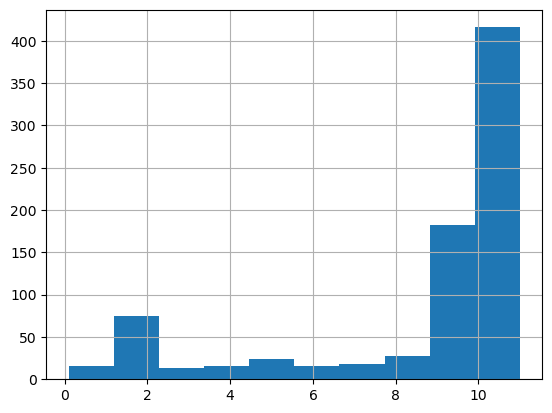

In [30]:
import numpy as np
from hmmlearn import hmm

def estimate_sleep_lengths_hmm(df, sleep_start_hour, sleep_end_hour, feature, resample_freq='3T', window_size=3, n_components=2):
    df['timestamp'] = pd.to_datetime(df['startDate'])
    df = df.drop_duplicates(subset=['timestamp']).sort_values(by=['timestamp'])

    # Create a new DataFrame with a fixed interval, merge and interpolate
    df_resampled = pd.DataFrame(pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq=resample_freq), columns=['timestamp'])
    df_resampled = pd.merge(df_resampled, df, on='timestamp', how='left').fillna(method='ffill')

    # Apply moving average filter to the feature
    df_resampled['filtered_feature'] = df_resampled[feature].rolling(window=window_size, min_periods=1).mean()

    # Prepare the feature data for the HMM
    feature_data = df_resampled['filtered_feature'].to_numpy().reshape(-1, 1)

    # Define a 2-state Gaussian HMM (sleep and wake states)
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000, init_params='stmcw')

    # Fit the HMM to the feature data
    model.fit(feature_data)

    # Get the most likely sleep/wake state sequence
    state_sequence = model.predict(feature_data)

    # Add the sleep/wake state sequence to the DataFrame
    df_resampled['sleep'] = state_sequence

    # Restrict sleep detection to the specified sleep window
    df_resampled['sleep'] = np.where((df_resampled['sleep'] == 1) & 
                                     ((df_resampled['timestamp'].dt.hour >= sleep_start_hour) | 
                                      (df_resampled['timestamp'].dt.hour < sleep_end_hour)), 1, 0)

    # Calculate estimated sleep hours for each day
    df_sleep = df_resampled.groupby(df_resampled['timestamp'].dt.floor('D')).agg({'sleep': 'sum'})
    df_sleep['sleep_hours'] = df_sleep['sleep'] * pd.to_timedelta(resample_freq).seconds / 3600

    return df_sleep, df_resampled

transition_matrix = np.array([[0.95, 0.05],
                              [0.1, 0.9]])

test, test_resampled = estimate_sleep_lengths_hmm(hr, feature="value", sleep_start_hour =22, sleep_end_hour=9, window_size=2)

print((test.sleep_hours > 0).sum()/len(test))

test[test.sleep_hours == 0] = np.nan

print(test.sleep_hours.mean())

print(test)

test.sleep_hours.hist()

[[ 58.      56.5962]
 [ 58.      56.5962]
 [ 58.      56.5962]
 ...
 [177.      58.8897]
 [177.      58.8897]
 [177.      58.8897]]


/home/sebastian/mambaforge/envs/pog4-sleep/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.5160220994475138
6.5936830835117775
                           sleep  sleep_hours
timestamp                                    
2020-09-25 00:00:00-04:00    NaN          NaN
2020-09-26 00:00:00-04:00    NaN          NaN
2020-09-27 00:00:00-04:00    NaN          NaN
2020-09-28 00:00:00-04:00   24.0     2.000000
2020-09-29 00:00:00-04:00  132.0    11.000000
...                          ...          ...
2023-03-14 00:00:00-04:00   40.0     3.333333
2023-03-15 00:00:00-04:00  132.0    11.000000
2023-03-16 00:00:00-04:00  132.0    11.000000
2023-03-17 00:00:00-04:00  132.0    11.000000
2023-03-18 00:00:00-04:00    1.0     0.083333

[905 rows x 2 columns]


<Axes: >

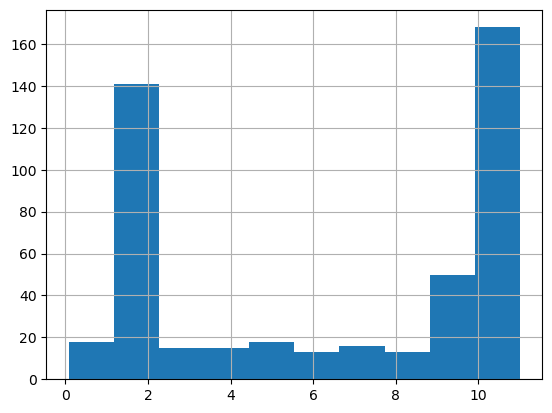

In [41]:
def estimate_sleep_lengths_hmm(hr_df, hrv_df, sleep_start_hour, sleep_end_hour, hr_feature, hrv_feature, resample_freq='5T', window_size=3, n_components=2):
    # rename column value to hr_value
    hr_feature = "hr_" + hr_feature
    hrv_feature = "hrv_" + hrv_feature
    
    hr_df = hr_df.rename(columns={'value': hr_feature})
    hrv_df = hrv_df.rename(columns={'value': hrv_feature})

    
    
    hr_df['timestamp'] = pd.to_datetime(hr_df['startDate'])
    hrv_df['timestamp'] = pd.to_datetime(hrv_df['startDate'])

    hr_df = hr_df.drop_duplicates(subset=['timestamp']).sort_values(by=['timestamp'])
    hrv_df = hrv_df.drop_duplicates(subset=['timestamp']).sort_values(by=['timestamp'])

    # Create a new DataFrame with a fixed interval, merge and interpolate
    df_resampled = pd.DataFrame(pd.date_range(start=hr_df['timestamp'].min(), end=hr_df['timestamp'].max(), freq=resample_freq), columns=['timestamp'])
    df_resampled = pd.merge(df_resampled, hr_df, on='timestamp', how='left').fillna(method='ffill').fillna(method='bfill')
    df_resampled = pd.merge(df_resampled, hrv_df, on='timestamp', how='left').fillna(method='ffill').fillna(method='bfill')

    # Apply moving average filter to the heart rate and HRVSDNN features
    df_resampled['filtered_hr'] = df_resampled[hr_feature].ewm(span=window_size).mean()
    df_resampled['filtered_hrv'] = df_resampled[hrv_feature].ewm(span=window_size).mean()

    # Prepare the feature data for the HMM
    feature_data = df_resampled[['filtered_hr', 'filtered_hrv']].to_numpy()

    print(feature_data)
    
    # Define a Gaussian HMM (sleep and wake states)
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="diag", n_iter=1000, init_params='stmcw')

    # Fit the HMM to the feature data
    model.fit(feature_data)

    # Get the most likely sleep/wake state sequence
    state_sequence = model.predict(feature_data)

    # Add the sleep/wake state sequence to the DataFrame
    df_resampled['sleep'] = state_sequence

    # Restrict sleep detection to the specified sleep window
    df_resampled['sleep'] = np.where((df_resampled['sleep'] == 1) & 
                                     ((df_resampled['timestamp'].dt.hour >= sleep_start_hour) | 
                                      (df_resampled['timestamp'].dt.hour < sleep_end_hour)), 1, 0)

    # Calculate estimated sleep hours for each day
    df_sleep = df_resampled.groupby(df_resampled['timestamp'].dt.floor('D')).agg({'sleep': 'sum'})
    df_sleep['sleep_hours'] = df_sleep['sleep'] * pd.to_timedelta(resample_freq).seconds / 3600

    return df_sleep

test = estimate_sleep_lengths_hmm(hr, hrv, hr_feature = "value", hrv_feature = "value", sleep_start_hour =22, sleep_end_hour=9, window_size=2)

print((test.sleep_hours > 0).sum()/len(test))

test[test.sleep_hours == 0] = np.nan

print(test.sleep_hours.mean())

print(test)

test.sleep_hours.hist()

In [54]:
hr = pd.read_csv('./data/xml_export/HeartRate.csv', low_memory=False)
#rhr = pd.read_csv('./data/xml_export/RestingHeartRate.csv', low_memory=False)
#
#hr = pd.concat([hr, rhr], axis=0)
hrv = pd.read_csv('./data/xml_export/HeartRateVariabilitySDNN.csv', low_memory=False)

# Only keep if creationDate is > 9/25/2020
hr = hr[hr['creationDate'] > '2020-09-25']
hrv = hrv[hrv['creationDate'] > '2020-09-25']

# Rename columns 
hr = hr.rename(columns={'startDate': 'Timestamp', 'value': 'HR'})
hrv = hrv.rename(columns={'startDate': 'Timestamp', 'value': 'HRV'})

def estimate_sleep_lengths(df_hr, df_hrv, hr_col='HR', hrv_col='HRV', hr_threshold=60, hrv_threshold=50, window_size=5):
    # Step 1: Merge the dataframes based on timestamps using an outer join
    df = pd.merge(df_hr, df_hrv, on='Timestamp', how='outer')
    
    # Step 2: Set the Timestamp as index and sort it
    df.set_index('Timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    
    # Drop duplicate timestamps if any
    df = df.loc[~df.index.duplicated(keep='first')]
    
    # Step 3: Resample the merged dataframe at a consistent interval (e.g., 5 minutes) and interpolate missing values
    df = df.resample('5T').interpolate()
    
    # Step 4: Smooth the data using a rolling window to reduce noise
    df[hr_col] = df[hr_col].rolling(window=window_size, center=True).mean()
    df[hrv_col] = df[hrv_col].rolling(window=window_size, center=True).mean()
    
    # Step 5: Set a threshold for HR and HRV to identify sleep intervals
    df['sleep'] = (df[hr_col] < hr_threshold) & (df[hrv_col] > hrv_threshold)
    
    sleep_df = df.resample('D')['sleep'].sum() * (df.index.freq.delta.total_seconds() / 3600)
    sleep_df = sleep_df.reset_index()
    sleep_df.columns = ['Date', 'sleep_hours']
    
    
    # # Step 6: Group the sleep intervals by date
    # df['Date'] = df.index.date
    # sleep_groups = df.groupby('Date')['Sleep']
    
    # # Step 7: Calculate the total sleep length for each date (in hours)
    # sleep_lengths = sleep_groups.sum() * 5 / 60 # Each interval is 5 minutes, so we divide by 60 to get hours
    
    # # Step 8: Create a new dataframe with the final output
    # sleep_df = sleep_lengths.reset_index()
    # sleep_df.columns = ['Date', 'sleep_hours']
    
    return sleep_df

test = estimate_sleep_lengths(hr, hrv)
print((test.sleep_hours > 0).sum()/len(test))

test[test.sleep_hours == 0] = np.nan

print(test.sleep_hours.mean())

print(test)



0.2883977900552486
13.422413793103448
                         Date  sleep_hours
0                         NaT          NaN
1                         NaT          NaN
2                         NaT          NaN
3                         NaT          NaN
4                         NaT          NaN
..                        ...          ...
900 2023-03-14 00:00:00-04:00     4.333333
901 2023-03-15 00:00:00-04:00     2.583333
902                       NaT          NaN
903                       NaT          NaN
904                       NaT          NaN

[905 rows x 2 columns]


In [ ]:
testIt seems to have a massive tradeoff between either very long sleep windows or none at all. Setting to 60 has 30% non-NaN values, but has a mean of 13 hour sleep lengths
